In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import json
from sklearn.utils import resample
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('CLEANED_WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])

In [3]:
from sklearn.utils import resample
# upsampling (bootstrapping samples in the minority group (yes) in Churn variable to address imbalanced class)
df_majority = df[df['Churn'] == 'No']
df_minority = df[df['Churn'] == 'Yes']

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)



In [4]:
target = 'Churn'
all_features = [
    'gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService',
    'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
    'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
    'Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges'
]
reduced_features = [f for f in all_features if f not in ['TotalCharges','gender','PhoneService']]


In [5]:
X = df_balanced[all_features]
y = df_balanced[target].map({'Yes': 1, 'No': 0})
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_red = X_train_full[reduced_features]
X_test_red = X_test_full[reduced_features]

In [6]:
# 4. Preprocessing
# Ordinal encoding for 'Contract'
ordinal_enc = OrdinalEncoder(categories=[['Month-to-month', 'One year', 'Two year']])

cat_full = [col for col in all_features if df[col].dtype == 'object' and col != 'Contract']
num_full = ['tenure', 'MonthlyCharges', 'TotalCharges']

cat_red = [col for col in reduced_features if df[col].dtype == 'object' and col != 'Contract']
num_red = ['tenure', 'MonthlyCharges']


In [7]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


preprocessor_full = ColumnTransformer([
    ("ord_contract", OrdinalEncoder(categories=[['Month-to-month','One year','Two year']]),["Contract"]),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False), cat_full),
    ("scale", StandardScaler(), num_full),
])

preprocessor_red = ColumnTransformer([
    ("ord_contract", OrdinalEncoder(categories=[['Month-to-month','One year','Two year']]), ["Contract"]),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False), cat_red),
    ("scale",   StandardScaler(), num_red),
])


In [8]:
pipe_full = Pipeline([
    ('pre', preprocessor_full),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

pipe_red = Pipeline([
    ('pre', preprocessor_red),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])


In [9]:
# 7. Grid search
param_grid_xgb = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}
grid_search_xgb = GridSearchCV(
    estimator=pipe_full,
    param_grid=param_grid_xgb,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    return_train_score=True
)

# Fit the model
grid_search_xgb.fit(X_train_full, y_train)

# Best parameters and best CV accuracy
print("Best parameters:", grid_search_xgb.best_params_)
print("Best CV accuracy:", grid_search_xgb.best_score_)


from sklearn.metrics import accuracy_score

y_train_pred = grid_search_xgb.predict(X_train_full)
y_test_pred = grid_search_xgb.predict(X_test_full)

# Training and testing accuracy
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

Best parameters: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
Best CV accuracy: 0.8785714285714284
Training Accuracy: 0.9879
Testing Accuracy: 0.8950

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1033
           1       0.85      0.96      0.90      1033

    accuracy                           0.89      2066
   macro avg       0.90      0.89      0.89      2066
weighted avg       0.90      0.89      0.89      2066


Confusion Matrix (Test Set):
[[860 173]
 [ 44 989]]


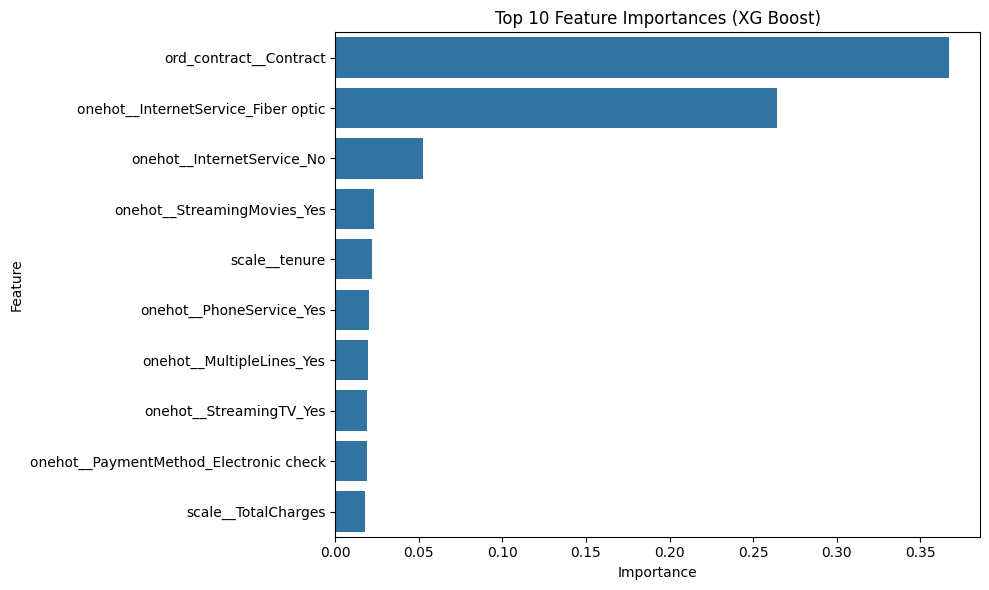

In [12]:
# Get the best model (already fitted on the full training set)
best_xgb_model = grid_search_xgb.best_estimator_

# extract the XG Boost classifier
xgb = best_xgb_model.named_steps['xgb']

# Get feature names from preprocessing step (if using ColumnTransformer)
preprocessor = best_xgb_model.named_steps['pre']
feature_names = preprocessor.get_feature_names_out()

# Get feature importances
importances = xgb.feature_importances_

# Turn into Dataframe
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances (XG Boost)')
plt.tight_layout()
plt.show()


In [13]:
print(feature_importance_df.head(10))

                                   Feature  Importance
0                   ord_contract__Contract    0.367424
6      onehot__InternetService_Fiber optic    0.264168
7               onehot__InternetService_No    0.052727
13             onehot__StreamingMovies_Yes    0.023349
18                           scale__tenure    0.021923
4                 onehot__PhoneService_Yes    0.020006
5                onehot__MultipleLines_Yes    0.019442
12                 onehot__StreamingTV_Yes    0.019046
16  onehot__PaymentMethod_Electronic check    0.018844
20                     scale__TotalCharges    0.018081


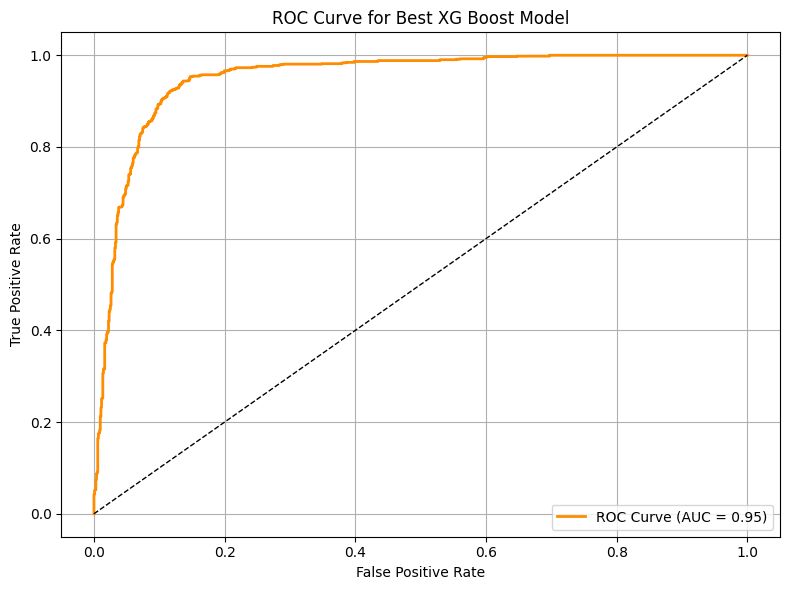

In [14]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (churn = 1)
y_proba = best_xgb_model.predict_proba(X_test_full)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best XG Boost Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

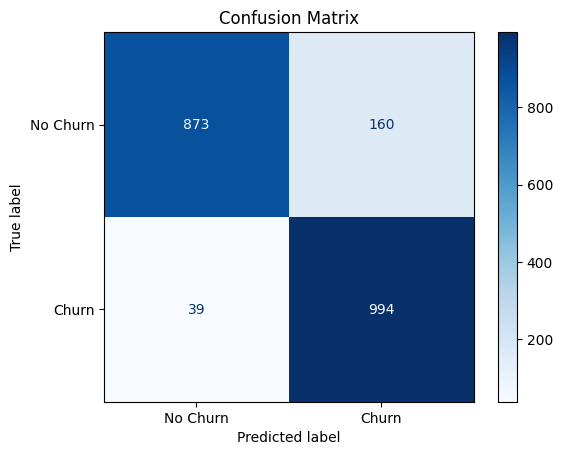

In [ ]:
# confusion matrix of best random forest model
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
